In [44]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import keras
from keras.models import * 
from keras.layers import *
import itertools
import zipfile
from PIL import Image
from keras.activations import *
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
shape = [128,128,3]

In [3]:
archive = zipfile.ZipFile("train.zip")
labels = pd.read_csv("labels.csv")

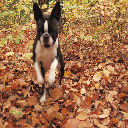

In [4]:
Image.open(archive.open(archive.filelist[1])).resize([128,128])

In [5]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
list_labels = list(set([i for i in labels["breed"].values]))
b2i = dict(zip(list_labels, itertools.count()))
i2b = dict(zip(itertools.count(), list_labels))

In [7]:
b2i["english_foxhound"]

38

In [8]:
i2b[0]

'great_dane'

In [9]:
id2b = dict(zip(labels["id"], labels["breed"]))

In [10]:
eye = np.eye(len(list_labels))

In [11]:
archive.filelist[1]

<ZipInfo filename='train/000bec180eb18c7604dcecc8fe0dba07.jpg' compress_type=deflate filemode='-rw-r--r--' external_attr=0x4000 file_size=54775 compress_size=54651>

In [12]:
def get_pics(adrs):
    X = []
    y = []
    for i in adrs:
        if "jpg" in i.filename :
            intg = b2i[id2b[i.filename[i.filename.index("/")+1:i.filename.index(".")]]]
            y1 = eye[intg:intg+1,:]
            x1 = np.array(Image.open(archive.open(i.filename)).resize(shape[:-1])).astype(np.float32)
            X.append(x1)
            y.append(y1)
    X = (np.array(X)/ 255.0).astype(np.float32) 
    y = np.array(y).astype(np.float32)
    return X, y.reshape((-1, len(list_labels)))

In [13]:
def get_data(batch_size, list1):
    current_batch = 0
    while True :
        
        end = min(current_batch + batch_size, len(list1))
        
        X, y = get_pics(list1[current_batch:end])
        
        current_batch += batch_size
        if not (current_batch < len(list1)):
            current_batch = 0
            
        yield X, y

In [14]:
list1=archive.filelist
np.random.shuffle(list1)

In [15]:
def get_model(batchNorm = True):
    in1 = Input(shape)
#     128*128*3 = 49,152
    X = Conv2D(32, [5,5], strides=[2,2], padding="SAME", activation=relu)(in1)
#     64,64,32
    X = Conv2D(32, [5,5], strides=[2,2], padding="SAME", activation=relu)(X)
    if batchNorm :
        X = BatchNormalization()(X)
#     32,32,32
    X = Conv2D(64, [5,5], strides=[2,2], padding="SAME", activation=relu)(X)    
    if batchNorm :
        X = BatchNormalization()(X)
#     16*16*64
    X = Conv2D(64, [5,5], strides=[2,2], padding="SAME", activation=relu)(X)
    if batchNorm :
        X = BatchNormalization()(X)
#     8*8*64
    X = Conv2D(128, [5,5], strides=[2,2], padding="SAME", activation=relu)(X)
    if batchNorm :
        X = BatchNormalization()(X)
#     4*4*128 = 2048

    X = Flatten()(X)
    X = Dense(1024, activation=relu)(X)
    X = Dense(256, activation=relu)(X)
    X = Dense(len(list_labels), activation=softmax)(X)
    
    
    model = Model(in1, X)
    
    
    return model

    

In [34]:
model = get_model()

In [17]:
model_doesnt_work_well = get_model(batchNorm=False)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          102464    
__________

In [35]:
model.compile(keras.optimizers.adam(lr=1e-3), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
model_doesnt_work_well.compile(keras.optimizers.adam(lr=1e-3), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [31]:
epochs = 2

In [21]:
for i in range(epochs):
    for X, y in get_data(1024, list1):
        model_doesnt_work_well.fit(X, y, batch_size=32, epochs=30)
        break
    break

Epoch 1/30
1024/1024 [==============================] - 3s 3ms/step - loss: 4.7880 - acc: 0.0078
Epoch 2/30
1024/1024 [==============================] - 1s 666us/step - loss: 4.7714 - acc: 0.0098
Epoch 3/30
1024/1024 [==============================] - 1s 677us/step - loss: 4.7526 - acc: 0.0068
Epoch 4/30
1024/1024 [==============================] - 1s 673us/step - loss: 4.7382 - acc: 0.0117
Epoch 5/30
1024/1024 [==============================] - 1s 666us/step - loss: 4.7322 - acc: 0.0068
Epoch 6/30
1024/1024 [==============================] - 1s 690us/step - loss: 4.7299 - acc: 0.0107
Epoch 7/30
1024/1024 [==============================] - 1s 694us/step - loss: 4.7250 - acc: 0.0098
Epoch 8/30
1024/1024 [==============================] - 1s 668us/step - loss: 4.7245 - acc: 0.0088
Epoch 9/30
1024/1024 [==============================] - 1s 685us/step - loss: 4.7261 - acc: 0.0146
Epoch 10/30
1024/1024 [==============================] - 1s 688us/step - loss: 4.7711 - acc: 0.0098
Epoch 11/30

In [36]:
del(X)
del(y)
del(model_doesnt_work_well)
tic = time.time()
for i in range(epochs):
    for X, y in get_data(4096, list1):
        model.fit(X, y, batch_size=32, epochs=4)
#     if i % 5 == 0 :
    toc = time.time()
    tic = toc
    print(toc - tic)
    print("epochs:",i)
    print(model.evaluate(X, y)[1])

Epoch 1/4
4096/4096 [==============================] - 4s 1ms/step - loss: 4.8285 - acc: 0.0186
Epoch 2/4
4096/4096 [==============================] - 3s 742us/step - loss: 4.5857 - acc: 0.0349
Epoch 3/4
4096/4096 [==============================] - 3s 738us/step - loss: 4.3626 - acc: 0.0566
Epoch 4/4
4096/4096 [==============================] - 3s 739us/step - loss: 4.0628 - acc: 0.0881
Epoch 1/4
4096/4096 [==============================] - 3s 744us/step - loss: 4.5436 - acc: 0.0349
Epoch 2/4
4096/4096 [==============================] - 3s 735us/step - loss: 4.1820 - acc: 0.0732 
Epoch 3/4
4096/4096 [==============================] - 3s 739us/step - loss: 3.7248 - acc: 0.1345
Epoch 4/4
4096/4096 [==============================] - 3s 739us/step - loss: 3.0184 - acc: 0.2749
Epoch 1/4
2030/2030 [==============================] - 2s 764us/step - loss: 4.5465 - acc: 0.0384
Epoch 2/4
2030/2030 [==============================] - 2s 743us/step - loss: 3.5992 - acc: 0.1552
Epoch 3/4
2030/2030 [

KeyboardInterrupt: 

In [39]:
epochs = 10
del(X)
del(y)
tic = time.time()
for i in range(epochs):
    for X, y in get_data(4096, list1):
        model.fit(X, y, batch_size=32)

Epoch 1/1
4096/4096 [==============================] - 3s 756us/step - loss: 0.0017 - acc: 1.0000
Epoch 1/1
4096/4096 [==============================] - 3s 745us/step - loss: 0.9662 - acc: 0.7234 1s - loss: 1.06
Epoch 1/1
2030/2030 [==============================] - 2s 757us/step - loss: 0.8818 - acc: 0.7507
Epoch 1/1
4096/4096 [==============================] - 3s 743us/step - loss: 0.5366 - acc: 0.8479
Epoch 1/1
4096/4096 [==============================] - 3s 745us/step - loss: 0.4987 - acc: 0.8567
Epoch 1/1
2030/2030 [==============================] - 2s 763us/step - loss: 0.3517 - acc: 0.8951
Epoch 1/1
4096/4096 [==============================] - 3s 731us/step - loss: 0.2710 - acc: 0.9204
Epoch 1/1
4096/4096 [==============================] - 3s 769us/step - loss: 0.2027 - acc: 0.9441
Epoch 1/1
2030/2030 [==============================] - 2s 760us/step - loss: 0.1733 - acc: 0.9542
Epoch 1/1
4096/4096 [==============================] - 3s 731us/step - loss: 0.1517 - acc: 0.9565
Epoc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-f5b9cf209dc4>", line 6, in <module>
    for X, y in get_data(4096, list1):
  File "<ipython-input-13-37dd0ce8ae59>", line 7, in get_data
    X, y = get_pics(list1[current_batch:end])
  File "<ipython-input-12-c0ad550e55bc>", line 8, in get_pics
    x1 = np.array(Image.open(archive.open(i.filename)).resize(shape[:-1])).astype(np.float32)
  File "C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py", line 1747, in resize
    self.load()
  File "C:\ProgramData\Anaconda3\lib\site-packages\PIL\ImageFile.py", line 231, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", l

KeyboardInterrupt: 

In [53]:
shape = [224, 224, 3]
# side note : let's talk about how to absorbe this models into our own models
if "resnet.h5" in os.listdir():
    print("loading model")
    model_res_net = load_model("resnet.h5")
else :
    model_res_net = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_shape=tuple(shape))
    model_res_net.save("resnet.h5")

102858752/102853048 [==============================] - 51s 0us/step


In [77]:
model_res_net.output

<tf.Tensor 'fc1000_1/Softmax:0' shape=(?, 1000) dtype=float32>

In [59]:
model_res_net.layers[-2]

In [128]:
def get_model_final_from_downloaded(model):
    output = model_res_net.layers[-2].output
    in1 = model.input
    X = Dense(1024, activation=relu)(output)
    X = Dense(len(list_labels), activation=softmax)(X)
    
    newModel = Model(in1, X)
    return newModel

In [129]:
new_model = get_model_final_from_downloaded(model_res_net)

In [130]:
new_model.compile(keras.optimizers.adam(lr=1e-3), keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [131]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [140]:
epochs = 100
del(X)
del(y)
for i in range(epochs):
    for X, y in get_data(1024, list1):
        new_model.fit(X, y, batch_size=32)

Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.5527 - acc: 0.0264
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.5717 - acc: 0.0264
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.5375 - acc: 0.0400
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.4946 - acc: 0.0371
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.5842 - acc: 0.0293
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.4766 - acc: 0.0420
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.4386 - acc: 0.0381
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 4.3864 - acc: 0.0381
Epoch 1/1
1023/1023 [==============================] - 15s 15ms/step - loss: 4.3536 - acc: 0.0489
Epoch 1/1
1007/1007 [==============================] - 15s 14ms/step - loss: 4.3728 - acc: 0.0497
Epoch 1/1
1024/1024 

1024/1024 [==============================] - 14s 14ms/step - loss: 2.1354 - acc: 0.4248
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 2.3212 - acc: 0.3662
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 2.1535 - acc: 0.4307
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 2.0811 - acc: 0.4404
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 2.1153 - acc: 0.4072
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 1.8930 - acc: 0.4868
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 1.9738 - acc: 0.4727
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 1.9581 - acc: 0.4590
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 1.9081 - acc: 0.4775
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 1.7655 - acc: 0.5156
Epoch 1/1
1024/1024 [=========

1024/1024 [==============================] - 14s 14ms/step - loss: 0.1294 - acc: 0.9678
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1457 - acc: 0.9600
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 0.1446 - acc: 0.9609
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 0.1815 - acc: 0.9464
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1715 - acc: 0.9541
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.2031 - acc: 0.9531
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1549 - acc: 0.9570
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1469 - acc: 0.9688
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1391 - acc: 0.9727
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1400 - acc: 0.9707
Epoch 1/1
1024/1024 [=========

1007/1007 [==============================] - 14s 14ms/step - loss: 0.0982 - acc: 0.9722
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1234 - acc: 0.9658
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1251 - acc: 0.9639
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1236 - acc: 0.9678
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1444 - acc: 0.9609
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1116 - acc: 0.9688
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0777 - acc: 0.9795
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0775 - acc: 0.9814
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0475 - acc: 0.9893
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 0.0563 - acc: 0.9844
Epoch 1/1
1007/1007 [=========

1024/1024 [==============================] - 14s 14ms/step - loss: 0.0536 - acc: 0.9863
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0701 - acc: 0.9766
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0521 - acc: 0.9844
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0731 - acc: 0.9795
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.1000 - acc: 0.9785
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0836 - acc: 0.9717
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 0.0970 - acc: 0.9717
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 0.0521 - acc: 0.9861
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0378 - acc: 0.9902
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0617 - acc: 0.9834
Epoch 1/1
1024/1024 [=========

1024/1024 [==============================] - 14s 14ms/step - loss: 0.0528 - acc: 0.9814
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0510 - acc: 0.9834
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0400 - acc: 0.9902
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 0.0334 - acc: 0.9902
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 0.0417 - acc: 0.9871
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0453 - acc: 0.9912
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0550 - acc: 0.9863
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0377 - acc: 0.9893
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0573 - acc: 0.9844
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0290 - acc: 0.9961
Epoch 1/1
1024/1024 [=========

1023/1023 [==============================] - 14s 14ms/step - loss: 0.0786 - acc: 0.9765
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 0.0439 - acc: 0.9851
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0415 - acc: 0.9873
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0392 - acc: 0.9893
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0452 - acc: 0.9854
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0281 - acc: 0.9932
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0247 - acc: 0.9941
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0504 - acc: 0.9893
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0336 - acc: 0.9902
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0294 - acc: 0.9922
Epoch 1/1
1023/1023 [=========

1024/1024 [==============================] - 14s 14ms/step - loss: 0.0619 - acc: 0.9814
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0563 - acc: 0.9863
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0543 - acc: 0.9834
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0433 - acc: 0.9873
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0353 - acc: 0.9893
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0269 - acc: 0.9902
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0283 - acc: 0.9902
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 0.0352 - acc: 0.9912
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 0.0312 - acc: 0.9921
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0568 - acc: 0.9795
Epoch 1/1
1024/1024 [=========

1024/1024 [==============================] - 14s 14ms/step - loss: 0.0495 - acc: 0.9863
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0529 - acc: 0.9854
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0505 - acc: 0.9863
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0496 - acc: 0.9854
Epoch 1/1
1023/1023 [==============================] - 14s 14ms/step - loss: 0.0228 - acc: 0.9922
Epoch 1/1
1007/1007 [==============================] - 14s 14ms/step - loss: 0.0250 - acc: 0.9921
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0253 - acc: 0.9941
Epoch 1/1
1024/1024 [==============================] - 14s 14ms/step - loss: 0.0307 - acc: 0.9922
Epoch 1/1
1024/1024 [==============================] - 15s 14ms/step - loss: 0.0348 - acc: 0.9873


KeyboardInterrupt: 